In [2]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Load label files
main_data = pd.read_csv("Image_classification_data/data_labels_mainData.csv")
extra_data = pd.read_csv("Image_classification_data/data_labels_extraData.csv")

In [4]:
# Set the correct path to your image folder (adjust this path!)
IMAGE_DIR = "Image_classification_data/patch_images/"  # UPDATE THIS to match your image folder

In [5]:
#EDA:

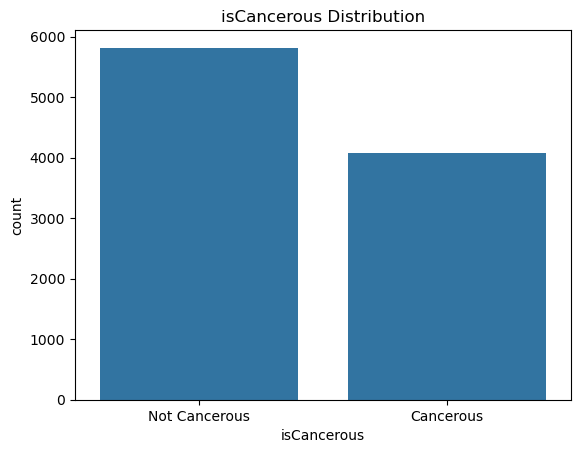

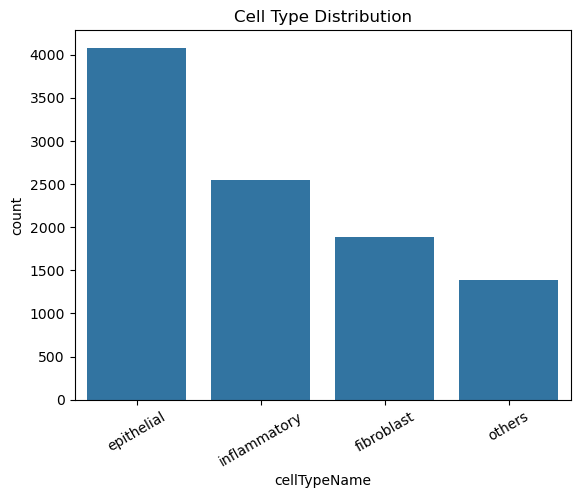

In [6]:
# Cancerous class distribution
sns.countplot(data=main_data, x='isCancerous')
plt.title("isCancerous Distribution")
plt.xticks([0, 1], ['Not Cancerous', 'Cancerous'])
plt.show()

# Cell type distribution
sns.countplot(data=main_data, x='cellTypeName', order=main_data['cellTypeName'].value_counts().index)
plt.title("Cell Type Distribution")
plt.xticks(rotation=30)
plt.show()

In [7]:
#Loading the images and flattening them

In [8]:
def load_images(df, label_col, image_col='ImageName', image_dir=IMAGE_DIR):
    X, y = [], []
    skipped = 0
    for _, row in df.iterrows():
        img_path = os.path.join(image_dir, row[image_col])
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB').resize((27, 27))
            X.append(np.array(img).flatten())
            y.append(row[label_col])
        else:
            print(f"Missing: {img_path}")
            skipped += 1
    print(f"Loaded: {len(X)} images | Skipped: {skipped}")
    return np.array(X), np.array(y)

In [9]:
#Binary Classification (isCancerous)

In [10]:
X_cancer, y_cancer = load_images(main_data, label_col='isCancerous')
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cancer, y_cancer, test_size=0.2, stratify=y_cancer)

model_cancer = RandomForestClassifier(n_estimators=100, random_state=42)
model_cancer.fit(X_train_c, y_train_c)
y_pred_c = model_cancer.predict(X_test_c)

print("Cancer Classification Report")
print(classification_report(y_test_c, y_pred_c, target_names=["Not Cancerous", "Cancerous"]))

Loaded: 9896 images | Skipped: 0
Cancer Classification Report
               precision    recall  f1-score   support

Not Cancerous       0.87      0.92      0.89      1164
    Cancerous       0.88      0.80      0.83       816

     accuracy                           0.87      1980
    macro avg       0.87      0.86      0.86      1980
 weighted avg       0.87      0.87      0.87      1980



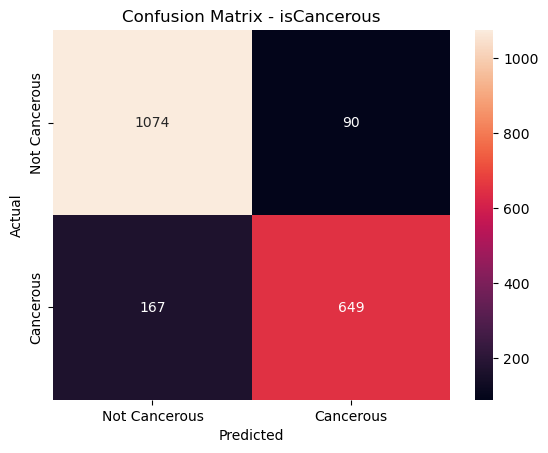

In [11]:
sns.heatmap(confusion_matrix(y_test_c, y_pred_c), annot=True, fmt='d',
            xticklabels=["Not Cancerous", "Cancerous"],
            yticklabels=["Not Cancerous", "Cancerous"])
plt.title("Confusion Matrix - isCancerous")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
#Multi-Class Classification (cellTypeName)

In [13]:
X_type, y_type = load_images(main_data, label_col='cellTypeName')

le = LabelEncoder()
y_type_enc = le.fit_transform(y_type)

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_type, y_type_enc, test_size=0.2, stratify=y_type_enc)

model_type = RandomForestClassifier(n_estimators=100, random_state=42)
model_type.fit(X_train_t, y_train_t)
y_pred_t = model_type.predict(X_test_t)

print("Cell Type Classification Report")
print(classification_report(y_test_t, y_pred_t, target_names=le.classes_))

Loaded: 9896 images | Skipped: 0
Cell Type Classification Report
              precision    recall  f1-score   support

  epithelial       0.76      0.91      0.83       816
  fibroblast       0.61      0.54      0.57       378
inflammatory       0.62      0.78      0.69       509
      others       0.64      0.06      0.12       277

    accuracy                           0.69      1980
   macro avg       0.66      0.57      0.55      1980
weighted avg       0.68      0.69      0.64      1980



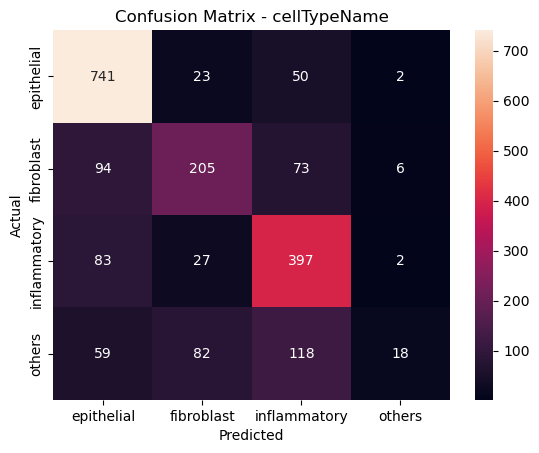

In [14]:
sns.heatmap(confusion_matrix(y_test_t, y_pred_t), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - cellTypeName")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
# Use Extra Data for Semi-Supervised Boosting. You can improve isCancerous model using extra labelled data:

In [16]:
combined_df = pd.concat([main_data[['ImageName', 'isCancerous']], extra_data[['ImageName', 'isCancerous']]])
X_combined, y_combined = load_images(combined_df, label_col='isCancerous')

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_combined, y_combined, test_size=0.2, stratify=y_combined)

Loaded: 20280 images | Skipped: 0


In [17]:
model_boosted = RandomForestClassifier(n_estimators=100, random_state=42)
model_boosted.fit(X_train_cb, y_train_cb)
y_pred_cb = model_boosted.predict(X_test_cb)

print("Boosted Model (with Extra Data)")
print(classification_report(y_test_cb, y_pred_cb))

Boosted Model (with Extra Data)
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      2642
           1       0.87      0.69      0.77      1414

    accuracy                           0.86      4056
   macro avg       0.86      0.82      0.83      4056
weighted avg       0.86      0.86      0.85      4056



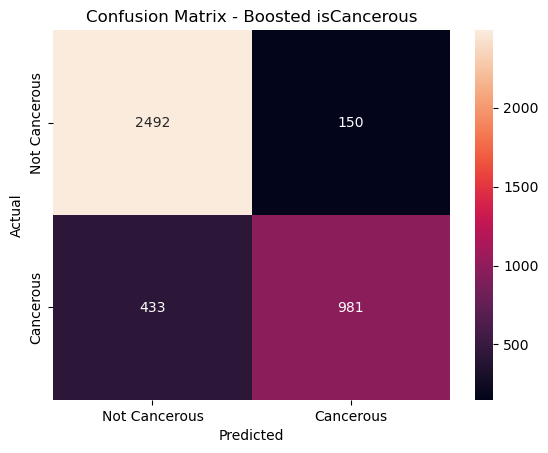

In [18]:
sns.heatmap(confusion_matrix(y_test_cb, y_pred_cb), annot=True, fmt='d',
            xticklabels=["Not Cancerous", "Cancerous"],
            yticklabels=["Not Cancerous", "Cancerous"])
plt.title("Confusion Matrix - Boosted isCancerous")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
# Data Preprocessing (Standardisation + PCA)

In [20]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA

# Standardise the cancer dataset
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_c)
X_test_std = scaler.transform(X_test_c)

# Normalise the cancer dataset
normalizer = Normalizer()
X_train_norm = normalizer.fit_transform(X_train_c)
X_test_norm = normalizer.transform(X_test_c)

# Apply PCA on standardised data
pca = PCA(n_components=50)  # Choose components to retain ~95% variance
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print(f"Original shape: {X_train_c.shape} → PCA shape: {X_train_pca.shape}")


Original shape: (7916, 2187) → PCA shape: (7916, 50)


In [ ]:
# Baseline: Linear Regression (for Cancer Classification)

In [22]:
from sklearn.linear_model import LogisticRegression, PoissonRegressor

# Logistic Regression (binary)
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_std, y_train_c)
log_pred = log_model.predict(X_test_std)

print("Logistic Regression Report (isCancerous)")
print(classification_report(y_test_c, log_pred))

Logistic Regression Report (isCancerous)
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1164
           1       0.80      0.82      0.81       816

    accuracy                           0.84      1980
   macro avg       0.84      0.84      0.84      1980
weighted avg       0.84      0.84      0.84      1980



In [25]:
#  Hyperparameter Tuning (RandomisedSearch Example)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a smaller, randomized search space
random_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Run randomized search with 5 iterations and full CPU usage
rand_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=random_grid,
    n_iter=5,  # Limits to 5 random combinations
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
rand_search.fit(X_train_c, y_train_c)

# Display best parameters and performance
print(f"✅ Best parameters: {rand_search.best_params_}")
print(f"🎯 Best F1 score (macro avg): {rand_search.best_score_:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  33.8s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  33.9s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=  34.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time= 1.0min
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  55.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=  56.7s
